In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix

import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt

In [2]:
# Installer CUDA, CUDNN
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print("Nombre de GPU disponible : ", len(gpus))

Nombre de GPU disponible :  1


In [3]:
# On se déplace dans le dossier images
os.chdir('data/images')

In [4]:
# On supprimer les dossiers de modélisations et leurs contenus si déjà éxistants dans images
_ = [shutil.rmtree(path) for path in ["train","valid","test"] if os.path.isdir(path) is True ]

In [5]:
list_dir_breeds = os.listdir()

In [6]:
# On observe le nombre d'images pour chaque races dans leur dossier respectifs
df_breds = pd.DataFrame([[f"{path:40}",len(os.listdir(path))] for path in list_dir_breeds] , columns=["race", "nombre_images"])
df_breds

,race,nombre_images
0,n02085620-Chihuahua,152
1,n02085782-Japanese_spaniel,185
2,n02085936-Maltese_dog,252
3,n02086079-Pekinese,149
4,n02086240-Shih-Tzu,214
...,...,...
115,n02113799-standard_poodle,159
116,n02113978-Mexican_hairless,155
117,n02115641-dingo,156
118,n02115913-dhole,150


In [7]:
n_breeds = 2
list_dir_breeds = random.sample(list_dir_breeds, n_breeds)

In [8]:
list_dir_breeds

['n02092339-Weimaraner', 'n02097130-giant_schnauzer']

In [9]:
# Organiser les données en un dossier d'entrainement, de validation et de test
for dir_breeds in list_dir_breeds:
    path_train = f"train/{dir_breeds}"
    path_valid = f"valid/{dir_breeds}"
    path_test = f"test/{dir_breeds}"
    
    # On crée nos dossiers vides
    [os.makedirs(path) for path in [path_train,path_valid,path_test] if os.path.isdir(path) is False]

In [10]:
# On base notre split sur le nombre d'images minimum
min_images = df_breds["nombre_images"].min()
train_size, valid_size, test_size = [int(0.7*min_images) , int(0.2*min_images), int(0.1*min_images)]

In [11]:
# Train Test Split
for dir_breeds in list_dir_breeds:
    path_train = f"train/{dir_breeds}"
    path_valid = f"valid/{dir_breeds}"
    path_test = f"test/{dir_breeds}"
    
    # Si nos dossiers sont vides
    if len(os.listdir(path_train)+os.listdir(path_valid)+os.listdir(path_test)) == 0:

        list_path_images = os.listdir(path=dir_breeds)
        
        # On ajoute le nombre d'images choisi pour l'entrainement, la validation et le test
        for path_image in random.sample(list_path_images, train_size):
            shutil.copy(f"{dir_breeds}/{path_image}", path_train)
            list_path_images.remove(path_image)

        for path_image in random.sample(list_path_images, valid_size):
            shutil.copy(f"{dir_breeds}/{path_image}", path_valid)
            list_path_images.remove(path_image)

        for path_image in random.sample(list_path_images, test_size):
            shutil.copy(f"{dir_breeds}/{path_image}", path_test)
            list_path_images.remove(path_image)
    else:
        print("Les dossiers ne sont pas vides")
        break

In [12]:
os.chdir('../../')

In [13]:
train_path = "data/images/train"
valid_path = "data/images/valid"
test_path = "data/images/test"

In [14]:
batch_size=10

In [15]:
# Création des itérateurs de données pour notre modélisation
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=list_dir_breeds, batch_size=batch_size)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=list_dir_breeds, batch_size=batch_size)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=list_dir_breeds, batch_size=batch_size, shuffle=False)

Found 206 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [16]:
imgs, labels = next(train_batches)

In [17]:
def plot_images(images_arr, labels=None, print_shape=True):
    size = len(images_arr)
    fig, axes = plt.subplots(1, size, figsize=(20,20))
    axes = axes.flatten()
    for i, (img, ax) in enumerate(zip( images_arr, axes)):
        img = (img+128).astype(np.uint8)
        ax.imshow(img)
        if labels is not None:
            ax.set_title(labels[i])
        elif print_shape is True :
            ax.set_title(np.array(img).shape)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

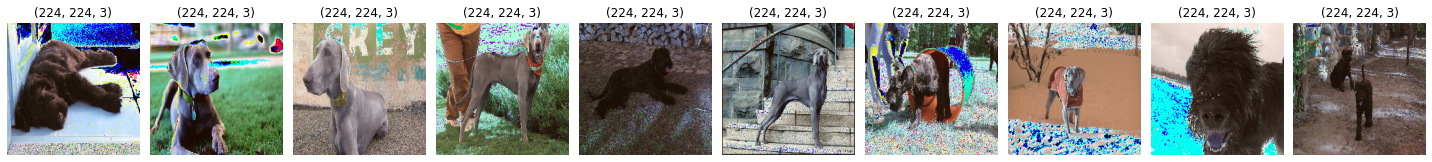

In [18]:
plot_images(imgs, print_shape=True)

**CNN**

In [19]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=n_breeds, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
21/21 - 7s - loss: 25.0977 - accuracy: 0.6505 - val_loss: 6.8110 - val_accuracy: 0.7586
Epoch 2/10
21/21 - 1s - loss: 5.6999 - accuracy: 0.8252 - val_loss: 6.4049 - val_accuracy: 0.8793
Epoch 3/10
21/21 - 1s - loss: 2.5879 - accuracy: 0.9078 - val_loss: 4.4027 - val_accuracy: 0.8621
Epoch 4/10
21/21 - 1s - loss: 0.3805 - accuracy: 0.9612 - val_loss: 9.2256 - val_accuracy: 0.8276
Epoch 5/10
21/21 - 1s - loss: 1.9014 - accuracy: 0.8932 - val_loss: 3.4959 - val_accuracy: 0.8966
Epoch 6/10
21/21 - 1s - loss: 1.0936 - accuracy: 0.9515 - val_loss: 4.7176 - val_accuracy: 0.8966
Epoch 7/10
21/21 - 1s - loss: 0.3532 - accuracy: 0.9612 - val_loss: 5.8743 - val_accuracy: 0.8621
Epoch 8/10
21/21 - 1s - loss: 0.1175 - accuracy: 0.9951 - val_loss: 4.8397 - val_accuracy: 0.8966
Epoch 9/10
21/21 - 1s - loss: 0.0361 - accuracy: 0.9951 - val_loss: 4.6453 - val_accuracy: 0.8621
Epoch 10/10
21/21 - 1s - loss: 0.2437 - accuracy: 0.9660 - val_loss: 4.3285 - val_accuracy: 0.8793


In [23]:
#Afficher l'évolution par epoch
def plot_evolution(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Evolution de l'accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()

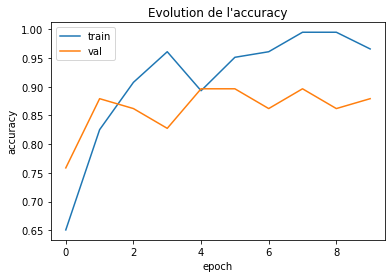

In [24]:
plot_evolution(history)

**Fine Tuning**

[VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION arxiv.org/pdf](https://arxiv.org/pdf/1409.1556.pdf)

During training, the input to our ConvNets is a fixed-size 224 × 224 RGB image.
The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel.
The image is passed through a stack of convolutional (conv.) layers, where we use filters with a very
small receptive field: 3 × 3 (which is the smallest size to capture the notion of left/right, up/down,
center).
In one of the configurations we also utilise 1 × 1 convolution filters, which can be seen as
a linear transformation of the input channels (followed by non-linearity). The convolution stride is
fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved
after convolution, i.e. the padding is 1 pixel for 3 × 3 conv. layers. Spatial pooling is carried out by
five max-pooling layers, which follow some of the conv. layers (not all the conv. layers are followed
by max-pooling). Max-pooling is performed over a 2 × 2 pixel window, with stride 2.
A stack of convolutional layers (which has a different depth in different architectures) is followed by
three Fully-Connected (FC) layers: the first two have 4096 channels each, the third performs 1000-
way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is
the soft-max layer. The configuration of the fully connected layers is the same in all networks.
All hidden layers are equipped with the rectification (ReLU (Krizhevsky et al., 2012)) non-linearity.
We note that none of our networks (except for one) contain Local Response Normalisation
(LRN) normalisation (Krizhevsky et al., 2012): as will be shown in Sect. 4, such normalisation
does not improve the performance on the ILSVRC dataset, but leads to increased memory consumption and computation time. Where applicable, the parameters for the LRN layer are those
of (Krizhevsky et al., 2012).

In [3]:
# On récupere le modele avec les poids entrainés
vgg16 = VGG16(weights="imagenet", include_top=True)

In [21]:
# On crée notre derniere couche à partir des couches précédentes de vgg16
last_layer = Dense(n_breeds, activation='softmax', name='predictions')(vgg16.layers[-2].output)

# Puis on crée notre modéle 
model = tf.keras.Model(inputs=vgg16.input, outputs=last_layer)

In [25]:
for layer in model.layers:
    layer.trainable = False

model.layers[-1].trainable =True

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

Epoch 1/10
21/21 - 17s - loss: 0.8713 - accuracy: 0.6311 - val_loss: 0.1692 - val_accuracy: 0.9655
Epoch 2/10
21/21 - 3s - loss: 0.1551 - accuracy: 0.9563 - val_loss: 0.0531 - val_accuracy: 0.9828
Epoch 3/10
21/21 - 3s - loss: 0.0743 - accuracy: 0.9854 - val_loss: 0.0369 - val_accuracy: 0.9828
Epoch 4/10
21/21 - 3s - loss: 0.0475 - accuracy: 0.9903 - val_loss: 0.0296 - val_accuracy: 0.9828
Epoch 5/10
21/21 - 3s - loss: 0.0348 - accuracy: 0.9903 - val_loss: 0.0270 - val_accuracy: 0.9828
Epoch 6/10
21/21 - 3s - loss: 0.0224 - accuracy: 0.9951 - val_loss: 0.0227 - val_accuracy: 0.9828
Epoch 7/10
21/21 - 3s - loss: 0.0155 - accuracy: 0.9951 - val_loss: 0.0194 - val_accuracy: 0.9828
Epoch 8/10
21/21 - 3s - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9828
Epoch 9/10
21/21 - 3s - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0155 - val_accuracy: 0.9828
Epoch 10/10
21/21 - 3s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0138 - val_accuracy: 1.0000


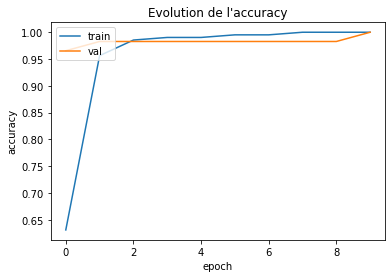

In [30]:
plot_evolution(history)